In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import json
from collections import OrderedDict
import tensorflow as tf
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [5]:
from agnfinder.tf_sampling import deep_emulator, api, run_sampler
from agnfinder.tf_sampling.api import SamplingProblem
from agnfinder.tf_sampling.hmc import SamplerHMC
from agnfinder import simulation_utils, simulation_samples
from agnfinder.prospector import visualise, main, cpz_builders

Using TensorFlow backend.


In [6]:
import arviz as az

In [7]:
tf.enable_eager_execution()

In [8]:
os.chdir('/home/mike/repos/agnfinder')

In [37]:
_, _, x_test, y_test = deep_emulator.data()
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [38]:
galaxy_n = 5
true_params = x_test[galaxy_n]
true_observation = deep_emulator.denormalise_photometry(y_test[galaxy_n])

In [10]:
galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)
# galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)

In [11]:
samples, _, _ = run_sampler.read_h5(galaxy_loc)

In [12]:
samples_by_chain = [samples[:, n, :] for n in range(samples.shape[1])]

In [13]:
param_names = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']

In [14]:
data = []
for chain_n, chain in enumerate(samples_by_chain):
    for sample_n, sample in enumerate(chain):
        series = dict(zip(param_names, sample))
        series['chain'] = chain_n
        series['sample'] = sample_n
        data.append(series)

In [15]:
df = pd.DataFrame(data)

In [16]:
df.head()

,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,chain,sample
0,0.554882,0.338813,0.636792,0.674759,0.129612,0.347483,0.060443,0,0
1,0.554882,0.338813,0.636792,0.674759,0.129612,0.347483,0.060443,0,1
2,0.547309,0.338991,0.639822,0.671037,0.130811,0.344034,0.056171,0,2
3,0.560273,0.349675,0.651050,0.660730,0.122801,0.339498,0.053095,0,3
4,0.558730,0.347687,0.641400,0.663725,0.124826,0.340779,0.054851,0,4


In [17]:
len(df)

576000

In [18]:
df_to_plot = df[param_names + ['chain']].query('chain < 5').sample(1000)

In [19]:
len(df_to_plot)

1000

 /media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:invalid value encountered in true_divide
 /media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:invalid value encountered in double_scalars


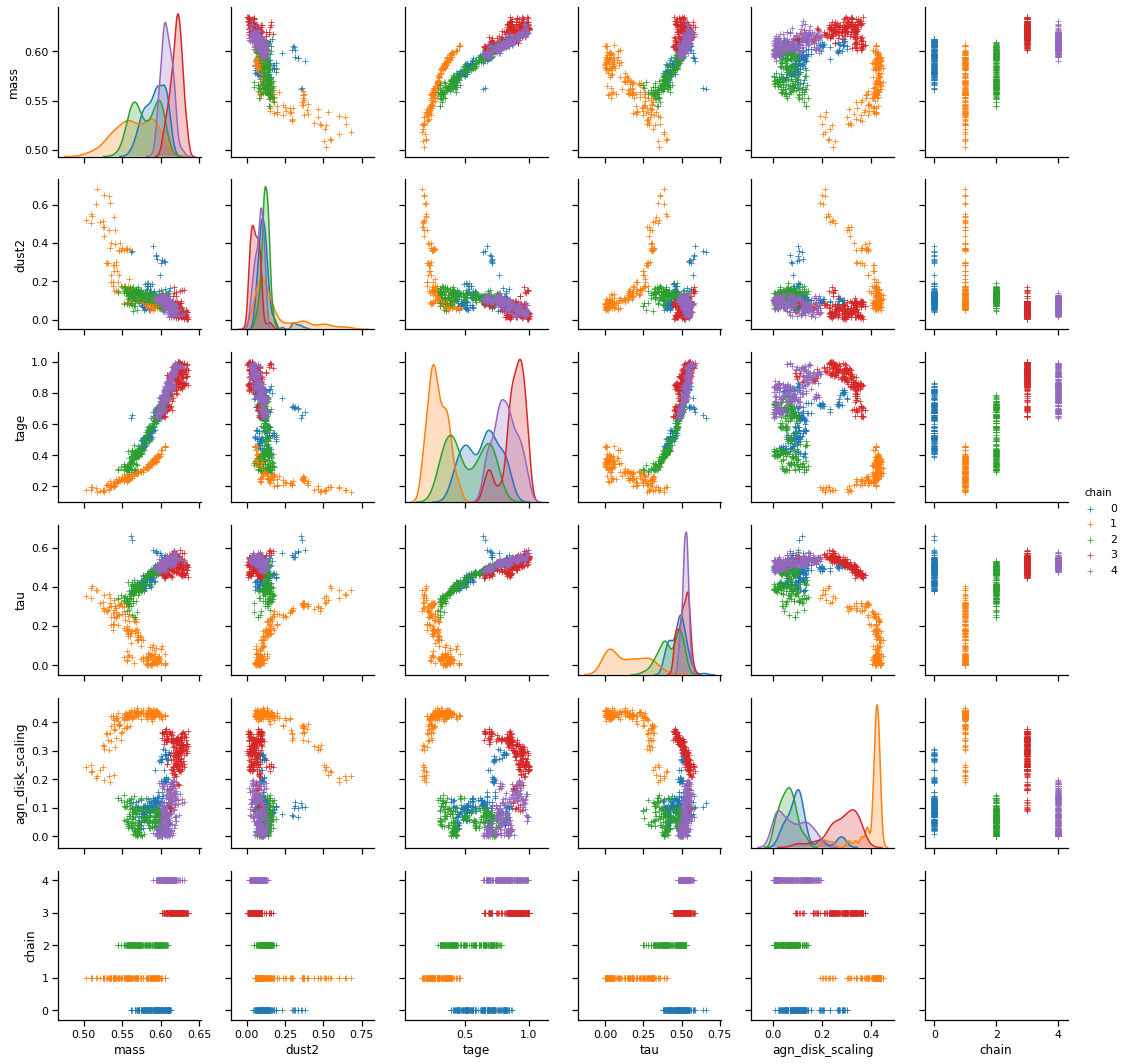

In [20]:
sns.pairplot(df_to_plot[['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'chain']], hue='chain', markers="+")

In [21]:
help(az.convert_to_dataset)

Help on function convert_to_dataset in module arviz.data.converters:

convert_to_dataset(obj, *, group='posterior', coords=None, dims=None)
    Convert a supported object to an xarray dataset.
    
    This function is idempotent, in that it will return xarray.Dataset functions
    unchanged. Raises `ValueError` if the desired group can not be extracted.
    
    Note this goes through a DataInference object. See `convert_to_inference_data`
    for more details. Raises ValueError if it can not work out the desired
    conversion.
    
    Parameters
    ----------
    obj : dict, str, np.ndarray, xr.Dataset, pystan fit, pymc3 trace
        A supported object to convert to InferenceData:
            InferenceData: returns unchanged
            str: Attempts to load the netcdf dataset from disk
            pystan fit: Automatically extracts data
            pymc3 trace: Automatically extracts data
            xarray.Dataset: adds to InferenceData as only group
            dict: creates a

In [29]:
ds = az.convert_to_dataset(np.swapaxes(samples, 0, 1)[:5], coords=dict(zip(param_names, range(len(param_names)))))  # first 5 chains, for clarity

In [30]:
ds

<xarray.Dataset>
Dimensions:  (chain: 5, draw: 6000, x_dim_0: 7)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 5993 5994 5995 5996 5997 5998 5999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6
Data variables:
    x        (chain, draw, x_dim_0) float32 0.554882 0.3388134 ... 0.13197827
Attributes:
    created_at:  2019-12-22T16:59:46.647069

In [32]:
help(az.plot_trace)

Help on function plot_trace in module arviz.plots.traceplot:

plot_trace(data, var_names=None, coords=None, divergences='bottom', figsize=None, textsize=None, lines=None, compact=False, combined=False, legend=False, plot_kwargs=None, fill_kwargs=None, rug_kwargs=None, hist_kwargs=None, trace_kwargs=None)
    Plot distribution (histogram or kernel density estimates) and sampled values.
    
    If `divergences` data is available in `sample_stats`, will plot the location of divergences as
    dashed vertical lines.
    
    Parameters
    ----------
    data : obj
        Any object that can be converted to an az.InferenceData object
        Refer to documentation of az.convert_to_dataset for details
    var_names : string, or list of strings
        One or more variables to be plotted.
    coords : mapping, optional
        Coordinates of var_names to be plotted. Passed to `Dataset.sel`
    divergences : {"bottom", "top", None, False}
        Plot location of divergences on the traceplo

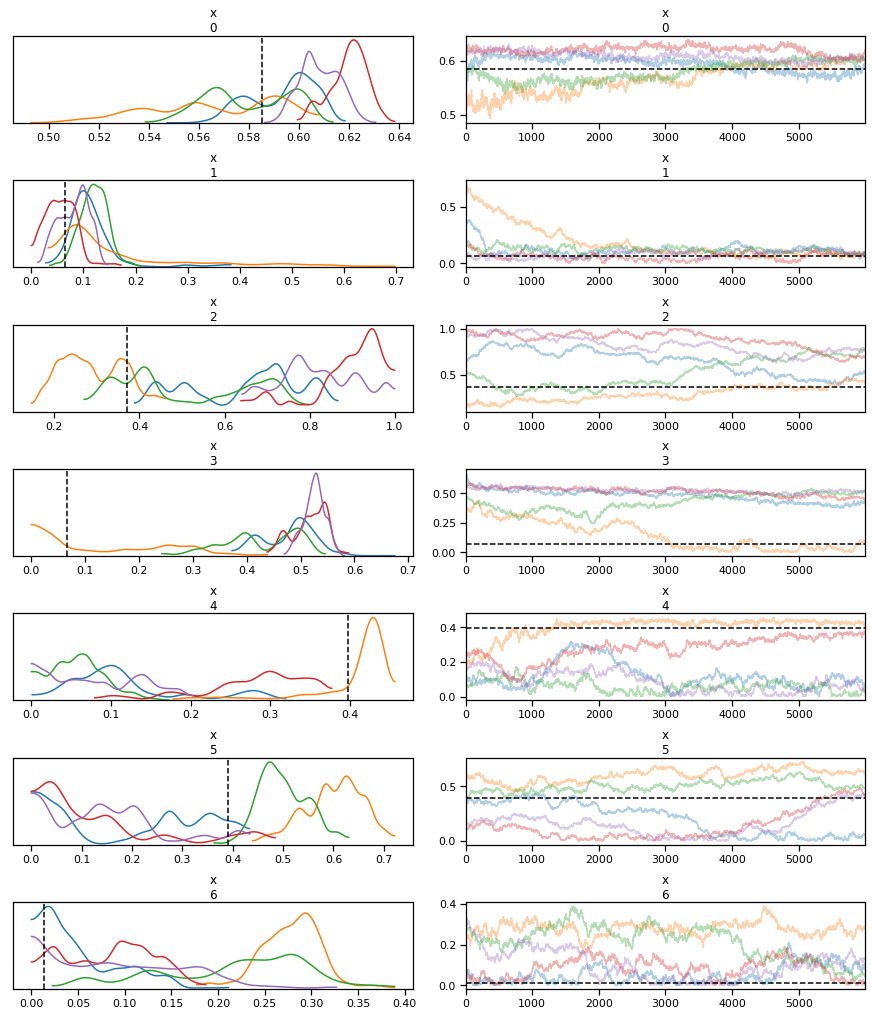

In [45]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b218b25d0>,
      dtype=object)